# Figure 7: Direct comparison of peak event performance

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @author: Sebastian Gegenleithner, Manuel Pirker

# Imports

In [2]:
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
# from ForecastModel.utils.postprocessing import *

import numpy as np
import pandas as pd

import json


## Functions

In [3]:
def find_best_models(data_lstm, data_arima):
    
    all_best = []
    normalized_arima = []
    normalized_lstm = []
    normalized_hydro = []
    
    all_absolute_errors_arima = []
    all_absolute_errors_lstm = []
    

    for i in range(0,96):
        arima_q0 = data_arima['fc%s' % i].values
        lstm_q0 = data_lstm['q%s' % i].values
        measured_q0 = data_arima['obs%s' % i].values
        
        num_best_arima = 0
        num_best_lstm = 0
        num_best_hydro = 0
        
        all_abs_error = []
        all_abs_error2 = []

        for j in range(0,len(arima_q0)):
            error_arima = abs(measured_q0[j] - arima_q0[j])
            error_lstm = abs(measured_q0[j] - lstm_q0[j])
            
            if error_arima < error_lstm:
                num_best_arima += 1
            if error_lstm < error_arima:
                num_best_lstm += 1
                
            
            all_abs_error.append(error_arima)
            all_abs_error2.append(error_lstm)

        all_absolute_errors_arima.append(all_abs_error)
        all_absolute_errors_lstm.append(all_abs_error2)

        list_best = [num_best_arima, num_best_lstm]
    
        all_best.append(list_best)
    
        normalized_arima.append(num_best_arima / (num_best_arima + num_best_lstm))
        normalized_lstm.append(num_best_lstm / (num_best_arima + num_best_lstm))
        normalized_hydro.append(num_best_hydro / (num_best_arima + num_best_lstm))
    
    return all_best, np.asarray(normalized_arima), np.asarray(normalized_lstm), all_absolute_errors_arima, all_absolute_errors_lstm


## Create model class

In [4]:
# model class 
class Model:
    def __init__(self, name, model_folder, n_trial=-1, target_name="", feat_hindcast=[], feat_forecast=[], is_external_model= False, is_final_model= False, color="r", ls="-"):
        self.name  = name
        self.color = color
        self.ls    = ls
        self.is_external_model = is_external_model
        
        if is_final_model:
            self.lg_path = model_folder
            self.hp_path = model_folder
            if is_external_model:
                is_external_model
                # do nothing
            else:
                with open(os.path.join(self.lg_path, "features.txt"), "r") as f:
                    dic = json.load(f)
                self.target_name   = dic["target_name"]
                self.feat_hindcast = dic["feat_hindcast"]
                self.feat_forecast = dic["feat_forecast"]
        else:
            self.lg_path = os.path.join(model_folder, "log", f"trial_{n_trial:02d}")
            self.hp_path = os.path.join(model_folder,  "hp", f"trial_{n_trial:02d}")
            self.target_name   = target_name
            self.feat_hindcast = feat_hindcast
            self.feat_forecast = feat_forecast

models = {
    "arima": Model("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "k",
                ls = "--",
                  ),
    "lstm_pbhm": Model("HLSTM-PBHM",
                           r"rst\HLSTM-PBHM",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          ),
     "lstm": Model("HLSTM",
                   r"rst\HLSTM",
                   is_final_model = True,
                   color = "#ff7f00",
                   ls = "-",
                 ),
     }
    

## Init

In [5]:
# plots
PLOT_PATH = r"plots"
DATA_PATH = r"data\Dataset.csv"

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

## Main

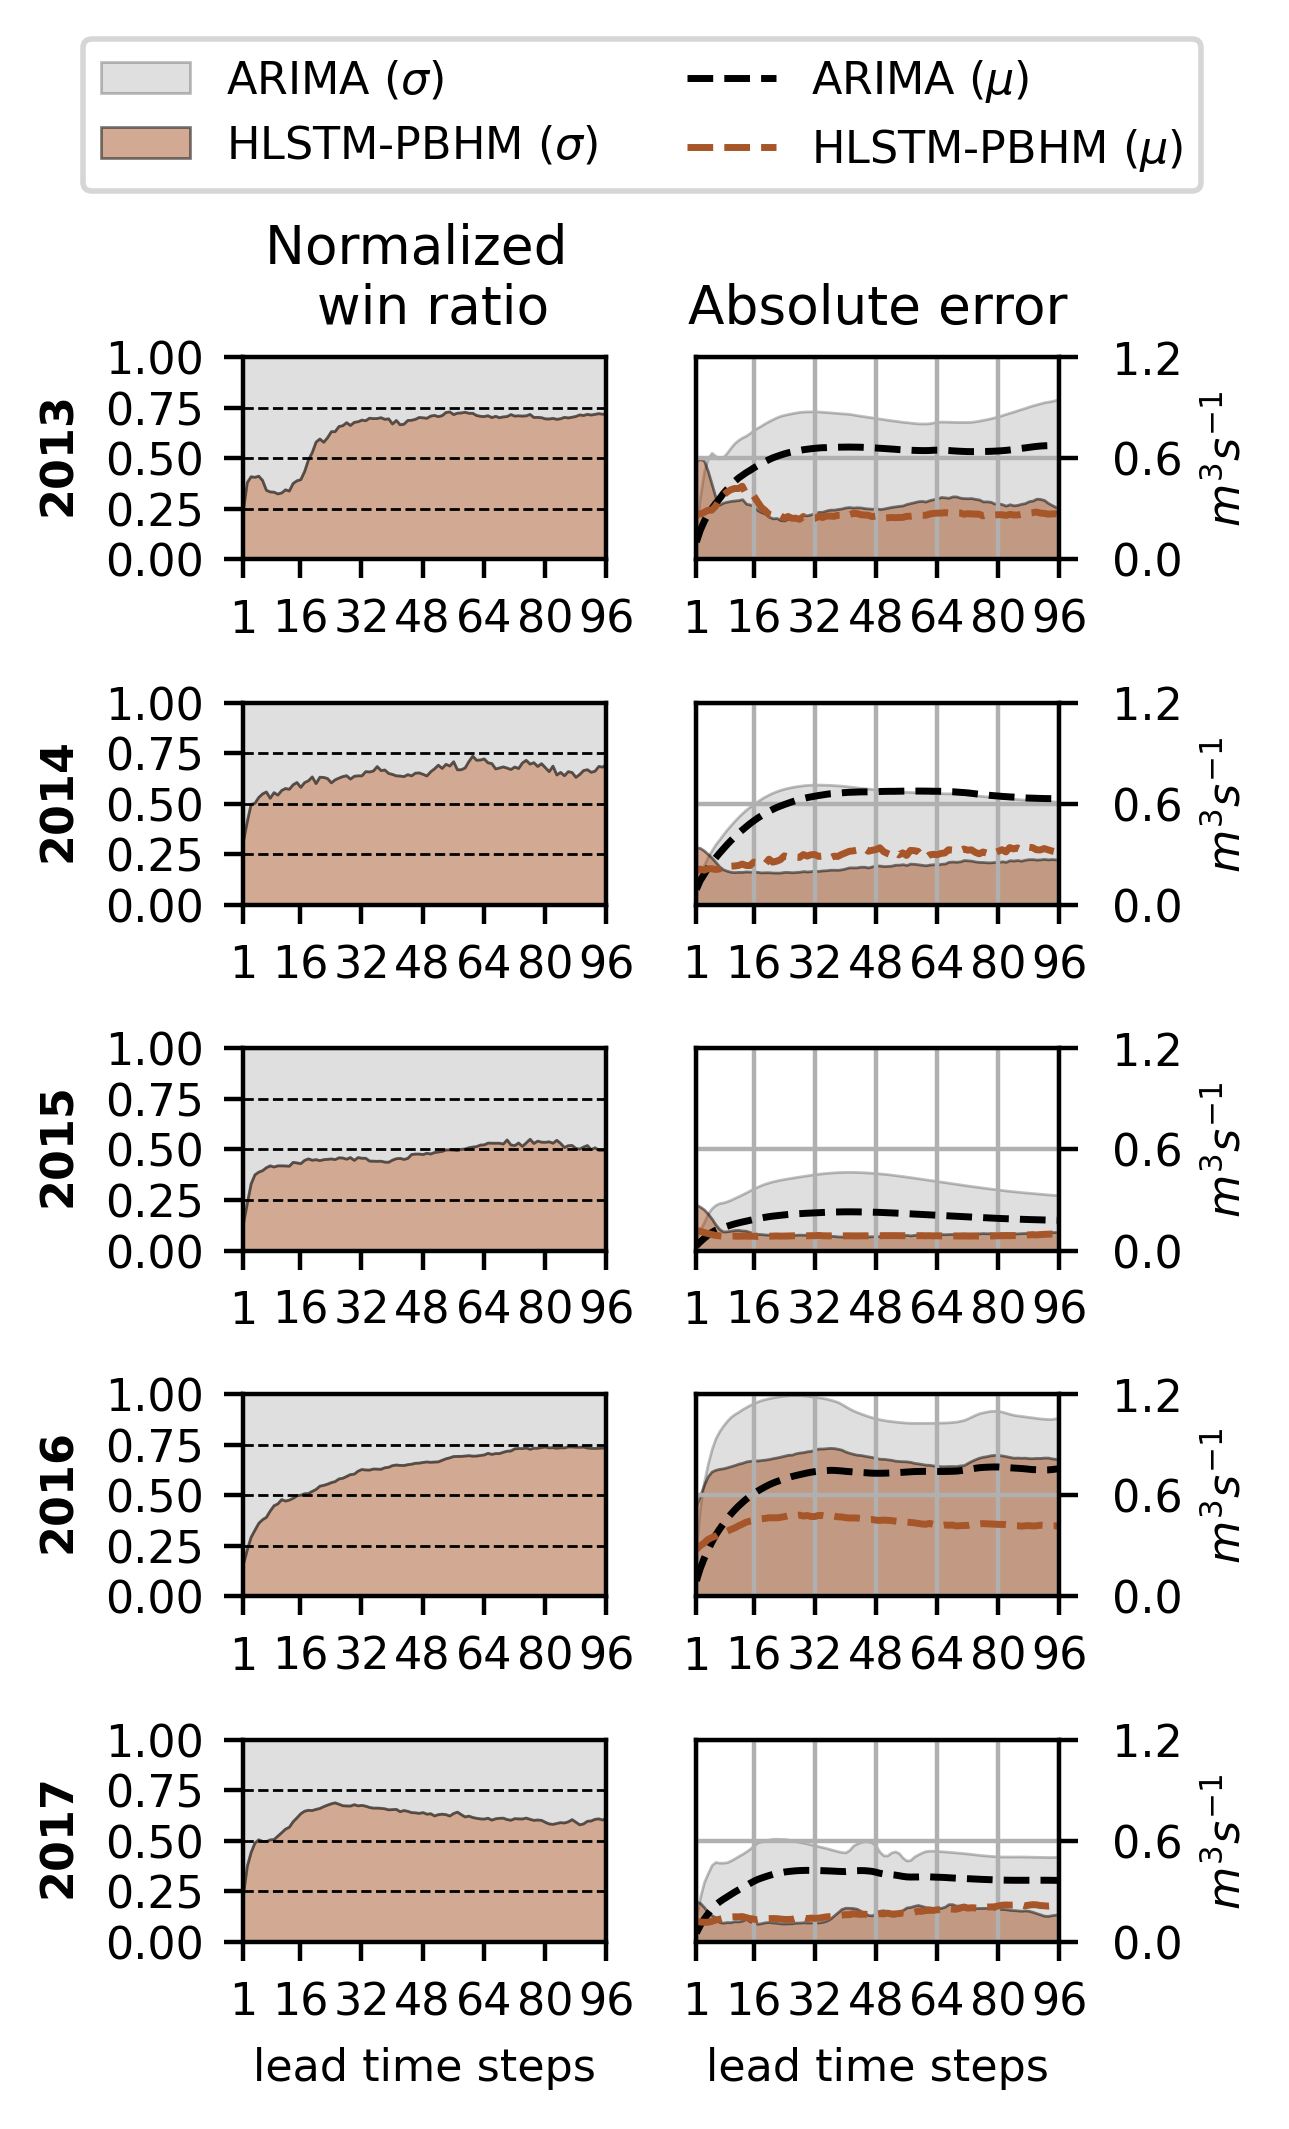

In [6]:
# create summary dataframe
df = pd.DataFrame(index=np.arange(2013,2018,dtype=int))

# process all folds
filepaths_lstm = [os.path.join(models["lstm_pbhm"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]
filepaths_arima = [os.path.join(models["arima"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]

all_abs_error_folds_arima = []
all_abs_error_folds_lstm = []
all_norm_arima = []
all_norm_hydro = []
all_norm_lstm = []

for i in range(0,len(filepaths_lstm)):
    year = 2013 + i
    
    data_lstm = pd.read_pickle(filepaths_lstm[i])
    data_arima = pd.read_pickle(filepaths_arima[i])

    # FIX UTC ------------------------------------------------------
    data_arima.index = pd.date_range(data_arima.index[0], data_arima.index[-1], freq="15min", tz="UTC")

    # make dfs the same size
    data_lstm  = data_lstm.loc[data_arima.index[0]:data_lstm.index[-2]]
    data_arima = data_arima.loc[:data_lstm.index[-1]]
    
    # top 5% discharge of the year
    peak_discharge_thresh = np.quantile(data_arima.obs0, 0.95)
    mask = data_arima.obs0 >= peak_discharge_thresh

    data_lstm_filtered  = data_lstm.loc[mask]
    data_arima_filtered = data_arima.loc[mask]

    all_best_list, normalized_arima, normalized_lstm, all_absolute_errors_arima, all_absolute_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)

    all_abs_error_folds_arima.append(all_absolute_errors_arima)
    all_abs_error_folds_lstm.append(all_absolute_errors_lstm)
    all_norm_arima.append(normalized_arima)
    all_norm_lstm.append(normalized_lstm)

    # percentage of ARIMA wins
    add_up = np.sum(all_best_list, axis=0)
    df.loc[year, "arima_first_step_wins_percent"] = all_best_list[0][0] / np.sum(all_best_list, axis=1)[0]
    df.loc[year, "arima_wins_percent"] = add_up[0] / np.sum(add_up)
    # lead time steps to outperform ARIMA in direct wins
    out_perform_idxs = [n for n, (x,y) in enumerate(all_best_list) if y-x > 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "wins"]       = out_perform_idxs[0]
        df.loc[year, "wins_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "wins"]       = -1
        df.loc[year, "wins_hours"] = -1
    # lead time steps to outperform ARIMA in AE
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.mean(np.abs(all_absolute_errors_arima), axis=1), 
            np.mean(np.abs(all_absolute_errors_lstm), axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "ae"]       = out_perform_idxs[0]
        df.loc[year, "ae_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "ae"]       = -1
        df.loc[year, "ae_hours"] = -1
    # lead time steps to outperform ARIMA in sigma
    out_perform_idxs = [n for n, (x,y) in enumerate(zip(
            np.std(np.abs(all_absolute_errors_arima), axis=1), 
            np.std(np.abs(all_absolute_errors_lstm), axis=1)
        )) if y-x < 0]
    if len(out_perform_idxs) > 0:
        df.loc[year, "sigma"]       = out_perform_idxs[0]
        df.loc[year, "sigma_hours"] = out_perform_idxs[0]*0.25
    else:
        df.loc[year, "sigma"]       = -1
        df.loc[year, "sigma_hours"] = -1
    

fig, axes = plt.subplots(5,2,figsize=(4.72*8.3/12,5), dpi=400)

num_entries = 96

x_values = np.arange(1,97)

limlist = [[-1.7,5.2],[-0.20,2.6],[-0.32,2.0],[-1.6,5.0],[-1.2,3.6]]
ticklist = [[-1.5, 0.0, 2.5, 5.0],
            [0.0, 0.8, 1.6, 2.4],
            [0.0, 0.6, 1.2, 1.8],
            [-1.4,0.0,2.4,4.8],
            [-1.0,0.0,1.8,3.6]]

k = 0
for i in range(0,5):
    
    x = np.arange(1,97)
    y_mean = np.asarray([np.mean(elem) for elem in all_abs_error_folds_arima[k]])
    y_std = np.asarray([np.std(elem) for elem in all_abs_error_folds_arima[k]])
    
    y_mean_lstm = np.asarray([np.mean(elem) for elem in all_abs_error_folds_lstm[k]])
    y_std_lstm = np.asarray([np.std(elem) for elem in all_abs_error_folds_lstm[k]])
    
    axes[i,1].plot(x, y_mean, color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std, y2=0, color='grey', label='ARIMA', alpha=0.25, edgecolor='black', linewidth=0.5)
    
    axes[i,1].plot(x, y_mean_lstm, color= '#a65628', linestyle = '--', label='HLSTM-PBHM ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std_lstm, y2=0, color='#a65628', label='HLSTM-PBHM', alpha=0.5, edgecolor='black', linewidth=0.5)
    
    #axes[i,1].yaxis.set_major_formatter(FormatStrFormatter(r'${:.2f}'))
    axes[i,1].set_xticks(np.array([1,16,32,48,64,80,96]))
    #axes[i,1].set_yticks(np.array(ticklist[i]))
    #axes[i,1].set_ylim(limlist[i][0],limlist[i][1])
    axes[i,1].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    axes[i,1].set_yticks([0,0.6,1.2])
    axes[i,1].set_ylim([0,1.2])
    
    axes[i,1].yaxis.set_major_formatter('{x: 4.1f}')
    
    #plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in np.array(ticklist[i])])
    
    #axes[i, j].set_ylim(-0.05, 1.05)
    axes[i,1].set_xlim(1, 96)
    #axes[i,j].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,1].grid()
    axes[i,1].set_ylabel("$m^3/s$")
    axes[i,1].set_ylabel("$m^3s^{-1}$")
    #axes[i,1].set_ylabel("$m^3/s$")
    axes[i,1].yaxis.set_label_position("right")
    axes[i,1].yaxis.set_ticks_position("right")
    k += 1


    
k = 0
for i in range(0,5):

    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=1, label='ARIMA ($\sigma$)', color = 'grey',edgecolor='black', linewidth=0.5, alpha=0.25)
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=0, label='HLSTM-PBHM ($\sigma$)', color = '#a65628',edgecolor='black', linewidth=0.5, alpha=0.5)

    axes[i,0].plot([], [], color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,0].plot([], [], color= '#a65628', linestyle = '--', label='HLSTM-PBHM ($\mu$)', linewidth=1.25)
    
    axes[i,0].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")
    #axes[i,0].set_ylabel(r"$\bf{"+f"fold\ {2013 + i}"+r"}$")
    axes[i,0].set_xticks(np.array([1,16,32,48,64,80,96]))
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_xlim(1,96)
    axes[i,0].set_yticks([0, 0.25,0.5,0.75,1])
    axes[i,0].grid(axis='y', linestyle='--', color='black', linewidth=0.5)

    k += 1

axes[4,0].set_xlabel('lead time steps')
axes[4,1].set_xlabel('lead time steps')
#axes[0,0].set_title('Normalized number \n of best model results')
axes[0,0].set_title('Normalized \n win ratio')
axes[0,1].set_title("Absolute error")


plt.tight_layout()
plt.subplots_adjust(top=0.89)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.6),
                  #title=r'$\bf{Direct \ comparison \ between \ correction \ schemes \ - \ Peaks}$',
                  loc='lower center', ncol=2, 
                  borderaxespad=1)

In [7]:
fig.savefig(os.path.join(PLOT_PATH, 'fig7_directandband_peaks_ae.png'), bbox_inches="tight", dpi=300)

## Dataframe results
used in cp. 4.2.2 line 313-320

In [8]:
df

,arima_first_step_wins_percent,arima_wins_percent,wins,wins_hours,ae,ae_hours,sigma,sigma_hours
2013,0.752005,0.367023,18.0,4.50,4.0,1.00,3.0,0.75
2014,0.682641,0.356591,3.0,0.75,3.0,0.75,4.0,1.00
2015,0.863820,0.525846,54.0,13.50,4.0,1.00,3.0,0.75
2016,0.839369,0.373424,15.0,3.75,5.0,1.25,2.0,0.50
2017,0.764140,0.389229,4.0,1.00,2.0,0.50,1.0,0.25


In [9]:
df.median()

arima_first_step_wins_percent     0.764140
arima_wins_percent                0.373424
wins                             15.000000
wins_hours                        3.750000
ae                                4.000000
ae_hours                          1.000000
sigma                             3.000000
sigma_hours                       0.750000
dtype: float64